# Installs

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get update

# install cartopy,
# per https://github.com/googlecolab/colabtools/issues/85#issuecomment-709241391 :
# not using `python-cartopy` package as it doesn't include all build dependencies
!apt-get install libproj-dev proj-bin proj-data
!apt-get install libgeos-dev
# shapely needs to be reinstalled to use the same geos install as cartopy (https://github.com/SciTools/cartopy/issues/871)
!pip uninstall -y shapely
!pip install --no-binary shapely shapely
!pip install cartopy

# install cfcrib
# needs eccodes, per https://pypi.org/project/cfgrib/ :

# from https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a 
# (this didn't work)
# !sudo apt-get install libeccodes-dev
#!echo 'export ECCODES_DIR=/usr/src/eccodes' >> ~/.bashrc
#!echo 'export ECCODES_DEFINITION_PATH=/usr/src/eccodes/share/eccodes/definitions' >> ~/.bashrc
#!source ~/.bashrc
#!sudo cp $ECCODES_DIR/lib/libeccodes.so /usr/lib
#!sudo cp /usr/src/eccodes/include/* /usr/include/
#!pip install eccodes-python

# https://pypi.org/project/cfgrib/0.8.4.5/ :
!sudo apt-get install libeccodes0

!python -m eccodes selfcheck
# !pip install eccodes 
!pip install cfgrib

# only needed for demo plots(?):
!pip install cmocean

# from SnowCast Showdown Data Wrangling.ipynb:
# Install GDAL and Geopandas
!apt-get install libgdal-dev 
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
# Install development version of geopandas from source per
# https://geopandas.org/en/stable/getting_started/install.html#installing-from-source 
# check if repo folder already exists, clone it otherwise:
![ ! -d "geopandas" ] && git clone https://github.com/geopandas/geopandas.git
!cd geopandas && pip install . --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 ht

In [2]:
!lsb_release -a
!python -m eccodes selfcheck

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
Found: ecCodes v2.6.0.
Library: libeccodes.so.0
Definitions: /MEMFS/definitions
Samples: /MEMFS/samples
Your system is ready.


# Data ingestion


In [3]:
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely import wkt


# Adapted from https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb :
import io
from datetime import date, timedelta

import xarray as xr
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# only for demo plots (?):
import matplotlib.pyplot as plt
import cmocean

# for cfgrib:
import eccodes
# Not used directly, but used via xarray
import cfgrib

import tempfile

In [4]:
# logging = False
logging = True

## Get dates and locations for which to retrieve weather data for
from https://ucbischool.slack.com/archives/C02USQ97D62/p1646622408601179 :

In [5]:
# on Colab with test file
# (generated as 
# !head -101 traindf_allregions.csv > traindf_allregions_head.csv )
traindf = pd.read_csv('traindf_allregions_head.csv').drop('Unnamed: 0', axis = 1)
# on AWS:
# traindf = pd.read_csv('~/SnowData/traindf_allregions.csv').drop('Unnamed: 0', axis = 1)

traindf['geometry'] = traindf['geometry'].apply(wkt.loads)

traindf = gpd.GeoDataFrame(traindf, geometry = 'geometry' , crs ="EPSG:4326")

if logging:
  print('Read in',len(traindf),'rows of training data')

# calculate overall lat/lon bounds for training data areas:
traindf_min_lon = min(traindf.geometry.bounds['minx'])
traindf_max_lon = max(traindf.geometry.bounds['maxx'])
traindf_min_lat = min(traindf.geometry.bounds['miny'])
traindf_max_lat = max(traindf.geometry.bounds['maxy'])
if logging:
    print('Bounding box for training areas (lat/lon):')
    print([traindf_min_lat, traindf_max_lat, traindf_min_lon, traindf_max_lon])

Read in 100 rows of training data
Bounding box for training areas (lat/lon):
[36.36132193462951, 39.81747295364354, -121.3240674967664, -118.2877618364424]


In [6]:
def get_hrrr(traindf, varname = 'TMP:surface', overwrite = False):
 
  colname = 'HRRR_' + varname.replace(':', '_')
  traindf[colname] = np.nan

  for thisdate in traindf.date.unique():
    thisdatestring = thisdate.replace('-','') 
    # todo?: work with proper datetime objects instead
    
    # Retrieve CONUS-wide image(s) for this date:
    # --- following part is partially adapted from 
    # https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb  :
    # Constants for creating the full URL
    # cf. https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources
    # and https://mesowest.utah.edu/html/hrrr/
    blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
    sector = "conus" # https://en.wikipedia.org/wiki/Contiguous_United_States 
    cycle = 12          # noon
    product = "wrfsfcf" # 2D surface levels
    forecast_hour = 0   # no forecast
    file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
    url = f"{blob_container}/hrrr.{thisdatestring}/{sector}/{file_path}"
    # version with datetime object:
    # url = f"{blob_container}/hrrr.{thisdate:%Y%m%d}/{sector}/{file_path}"
    if logging:
      print('Retrieving',varname,'image from',url)

    # Fetch the idx file by appending the .idx file extension to our already formatted URL
    r = requests.get(f"{url}.idx")
    blobnotfound_bool = (r.text.splitlines()[0].find('BlobNotFound') > 0)
    # todo: handle this error
    idx = r.text.splitlines()
    # Get byte range for the variable in question   
    var_idx = [l for l in idx if varname in l][0].split(":")    
    # Pluck the byte offset from this line, plus the beginning offset of the next line
    line_num = int(var_idx[0])
    range_start = var_idx[1]
    # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
    # but check we're not already reading the last line
    next_line = idx[line_num].split(':') if line_num < len(idx) else None    
    # Pluck the start of the next byte offset, or nothing if we were on the last line
    range_end = next_line[1] if next_line else None    

    file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)
    headers = {"Range": f"bytes={range_start}-{range_end}"}
    resp = requests.get(url, headers=headers, stream=True)
    with file as f:
        f.write(resp.content)
    # todo? (perf improvement): save file permanently for later runs

    # Open the GRIB2 file as an xarray dataset:
    ds = xr.open_dataset(file.name, engine='cfgrib', 
		  		 backend_kwargs={'indexpath':''})
    # --- end of part adapted from https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb 
    # get the name of our weather variable in the xarray dataset:
    xar_varname = list(ds.data_vars)[0]

    # Crop to a smaller area, discarding values irrelevant for our training data 
    # (to help avoid memory issues when upsampling)
    # todo? (further perf improvement): use individual training cells boundaries
    # instead of overal bounding box to discard even more irrelevant values
    # Keep a border for interpolation calculations etc.:
    safety_border_lon = 0.1 * (traindf_max_lon - traindf_min_lon)
    safety_border_lat = 0.1 * (traindf_max_lat - traindf_min_lat)
    traindf_mask_lon = (ds.longitude >= traindf_min_lon+360-safety_border_lon) &\
                       (ds.longitude <= traindf_max_lon+360+safety_border_lon)
    # NB: ASO uses signed longitudes, HRRR uses unsigned longitudes ("degrees east")
    traindf_mask_lat = (ds.latitude >= traindf_min_lat-safety_border_lat) &\
                       (ds.latitude <= traindf_max_lat+safety_border_lat)
    train_cropped_ds = ds.where(traindf_mask_lon & traindf_mask_lat, drop=True)

    # Upsample from original 3km resolution, 
    # aiming at interpolating 5 data points per 1km, i.e. 5*5 per 1km^2 cell
    # cf. https://xarray.pydata.org/en/stable/user-guide/interpolation.html#example :
    new_x = np.linspace(train_cropped_ds.x[0], train_cropped_ds.x[-1], \
                        train_cropped_ds.dims["x"] * 3*5)
    new_y = np.linspace(train_cropped_ds.y[0], train_cropped_ds.y[-1], \
                        train_cropped_ds.dims["y"] * 3*5)
    ds_upsampled = train_cropped_ds.interp(x=new_x, y=new_y)
    # interp() retains the old values of the index labels x and y 
    # as data variables (interpolated), but we don't need these 
    # and they would cause issues with cell cropping later:
    ds_upsampled = ds_upsampled.drop(['x','y']) 


    # For each cell location (rectangle) for this date, get the average value of 
    # the upsampled HRRR variable on grid points falling in that area
    # (as a good enough approximation of an actual integral that would take 
    # map projection into account):
    
    for this_cell_id in traindf.loc[traindf.date == thisdate].cell_id:
        # cf. get_copernicus() in  SnowCast Showdown Data Wrangling.ipynb :

        cell_min_lon = traindf.loc[traindf.cell_id == this_cell_id].\
            geometry.bounds['minx'].iloc[0]
        cell_min_lat = traindf.loc[traindf.cell_id == this_cell_id].\
            geometry.bounds['miny'].iloc[0]
        cell_max_lon = traindf.loc[traindf.cell_id == this_cell_id].\
            geometry.bounds['maxx'].iloc[0]
        cell_max_lat = traindf.loc[traindf.cell_id == this_cell_id].\
            geometry.bounds['maxy'].iloc[0]
        
        cell_mask_lon = (ds_upsampled.longitude >= cell_min_lon+360) &\
                        (ds_upsampled.longitude <= cell_max_lon+360)
        # NB: ASO uses signed longitudes, HRRR uses unsigned longitudes ("degrees east")
        cell_mask_lat = (ds_upsampled.latitude >= cell_min_lat) &\
                        (ds_upsampled.latitude <= cell_max_lat)

        cell_cropped_ds = ds_upsampled.where(cell_mask_lon & cell_mask_lat, drop=True)
        cell_mean = np.nanmean(cell_cropped_ds[xar_varname].values)
        
        traindf.loc[traindf.cell_id == this_cell_id , colname] = cell_mean
        
        if logging:
          print('Mean for',[cell_min_lon, cell_max_lon, cell_min_lat, cell_max_lat],\
                'is',cell_mean)




In [7]:
 %%time
 get_hrrr(traindf)

Retrieving TMP:surface image from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20160105/conus/hrrr.t12z.wrfsfcf00.grib2
Mean for [-120.6233815751532, -120.614398422312, 39.67242331310127, 39.6793373618521] is 272.30112653510963
Mean for [-119.6172684569393, -119.6082853040981, 38.27574773521515, 38.2827995148586] is 268.32579782038283
Mean for [-118.3506439063308, -118.3416607534896, 36.56361241293132, 36.57082730809418] is 264.582945158281
Mean for [-120.8838930075479, -120.8749098547067, 39.78296502318875, 39.78986799454153] is 272.82614580606025
Mean for [-119.554386387051, -119.5454032342098, 37.63117397089415, 37.63828790610744] is 270.5629686759628
Mean for [-119.5274369285274, -119.5184537756862, 37.39603231034729, 37.40316869633584] is 272.7439804271569
Mean for [-118.5572564216783, -118.5482732688371, 37.09569103644088, 37.10285592347675] is 265.1115001903241
Mean for [-119.7699820552397, -119.7609989023985, 38.24047856423864, 38.24753376800047] is 269.9952208508001
Mean fo

# Data exploration and testing

In [ ]:
print(traindf.iloc[0].geometry)

POLYGON ((-120.614398422312 39.67242331310127, -120.614398422312 39.6793373618521, -120.6233815751532 39.6793373618521, -120.6233815751532 39.67242331310127, -120.614398422312 39.67242331310127))


In [8]:
traindf

,cell_id,date,SWE,region,geometry,mean_inversed_swe,mean_local_swe,median_local_swe,max_local_swe,min_local_swe,mean_local_elevation,median_local_elevation,max_local_elevation,min_local_elevation,copernicus_filelocations,HRRR_TMP_surface
0,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6...",17.255057,10.348,10.80,23.06,0.00,1978.761600,2011.680000,2194.5600,1609.344000,/home/ubuntu/SnowData/CopernicusData/018cf1a1-...,260.279439
1,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2...",18.306146,11.260,9.30,21.60,4.70,2656.027189,2673.095947,2926.0800,2194.560000,/home/ubuntu/SnowData/CopernicusData/01be2cc7-...,254.034077
2,04b7603c-26c6-4004-a8bc-58b2b60e810e,2016-01-05,3.5,sierras,"POLYGON ((-118.34166 36.56361, -118.34166 36.5...",4.385146,4.712,3.44,7.25,2.52,2913.888000,3093.720000,3474.7200,2331.720000,/home/ubuntu/SnowData/CopernicusData/04b7603c-...,251.713413
3,147d5eb4-e574-47e4-994a-8a2908c06050,2016-01-05,11.7,sierras,"POLYGON ((-120.87491 39.78297, -120.87491 39.7...",12.326194,11.140,10.80,23.06,3.96,1961.083200,1975.104000,2225.0400,1609.344000,/home/ubuntu/SnowData/CopernicusData/147d5eb4-...,261.752254
4,174e3100-c30e-46a4-ac7c-30cd521fc390,2016-01-05,12.9,sierras,"POLYGON ((-119.54540 37.63117, -119.54540 37.6...",11.383223,11.696,10.50,20.38,7.32,2447.544000,2407.920000,2987.0400,2103.120000,/home/ubuntu/SnowData/CopernicusData/174e3100-...,252.347098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,a4e8e597-1c21-4a46-bf08-2ee5149c481c,2016-02-02,18.2,sierras,"POLYGON ((-118.56624 36.92353, -118.56624 36.9...",11.829936,13.666,11.11,24.87,5.96,3145.536000,3108.960000,3474.7200,2987.040000,/home/ubuntu/SnowData/CopernicusData/a4e8e597-...,243.467147
96,c89dc6ca-6d69-41ce-954d-b51f64aaacb1,2016-02-02,25.2,sierras,"POLYGON ((-120.03948 38.70465, -120.03948 38.7...",29.287933,28.274,23.50,37.20,21.72,2460.528466,2545.994400,2667.0000,2164.080000,/home/ubuntu/SnowData/CopernicusData/c89dc6ca-...,254.838227
97,d37da01c-d9d7-4cbf-985a-af44d5a3e1e9,2016-02-02,13.8,sierras,"POLYGON ((-119.86880 38.02850, -119.86880 38.0...",29.078466,28.608,30.72,36.12,19.80,2365.248000,2362.200000,2560.3200,2148.840000,/home/ubuntu/SnowData/CopernicusData/d37da01c-...,259.879288
98,d674ee8e-49f1-44c9-890d-4e04997522a1,2016-02-02,24.0,sierras,"POLYGON ((-119.91371 38.92164, -119.91371 38.9...",24.047618,19.740,19.10,24.10,17.80,2539.349781,2608.173584,2682.2400,2359.761719,/home/ubuntu/SnowData/CopernicusData/d674ee8e-...,258.377593


In [196]:
# testing  def get_hrrr(traindf, varname = 'TMP:surface', overwrite = False):
varname = 'TMP:surface' # temperature
# varname = 'GUST:surface' # wind
colname = 'HRRR_' + varname.replace(':', '_')
traindf[colname] = np.nan

# get example date:
thisdate = traindf.date.unique()[3]
thisdatestring = thisdate.replace('-','') 
# todo? work with proper datetime objects instead

# Retrieve CONUS-wide image(s) for this date:

# --- following part is partially adapted from 
# https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb  :
# Constants for creating the full URL
# cf. https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources
# and https://mesowest.utah.edu/html/hrrr/
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
sector = "conus" # https://en.wikipedia.org/wiki/Contiguous_United_States 
cycle = 12          # noon
product = "wrfsfcf" # 2D surface levels
forecast_hour = 0   # no forecast
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{thisdatestring}/{sector}/{file_path}"
# version with datetime object:
# url = f"{blob_container}/hrrr.{thisdate:%Y%m%d}/{sector}/{file_path}"
print('Retrieving',varname,'from',url)

# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url}.idx")
blobnotfound_bool = (r.text.splitlines()[0].find('BlobNotFound') > 0)
# todo: handle this error
idx = r.text.splitlines()

# Get byte range for the variable in question   
var_idx = [l for l in idx if varname in l][0].split(":")
print('var_idx =',var_idx)
# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(var_idx[0])
range_start = var_idx[1]
# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None    
# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None
print('range for',varname,':',range_start,'to',range_end)

file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)
headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
  f.write(resp.content)
# todo? (perf improvement): save file permanently for later runs

# Open the GRIB2 file as an xarray dataset:
ds = xr.open_dataset(file.name, engine='cfgrib', 
				 backend_kwargs={'indexpath':''})
# --- end of part adapted from https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb 
# get the name of our weather variable in the xarray dataset:
xar_varname = list(ds.data_vars)[0]

# Crop to a smaller area, discarding values irrelevant for our training data 
# (to help avoid memory issues when upsampling)
# todo? (further perf improvement): use individual training cells boundaries
# instead of overal bounding box to discard even more irrelevant values
# Keep a border for interpolation calculations etc.:
safety_border_lon = 0.1 * (traindf_max_lon - traindf_min_lon)
safety_border_lat = 0.1 * (traindf_max_lat - traindf_min_lat)
traindf_mask_lon = (ds.longitude >= traindf_min_lon+360-safety_border_lon) &\
                   (ds.longitude <= traindf_max_lon+360+safety_border_lon)
# NB: ASO uses signed longitudes, HRRR uses unsigned longitudes ("degrees east")
traindf_mask_lat = (ds.latitude >= traindf_min_lat-safety_border_lat) &\
                   (ds.latitude <= traindf_max_lat+safety_border_lat)
train_cropped_ds = ds.where(traindf_mask_lon & traindf_mask_lat, drop=True)


# Upsample from original 3km resolution, 
# aiming at interpolating 5 data points per 1km, i.e. 5*5 per 1km^2 cell
# cf. https://xarray.pydata.org/en/stable/user-guide/interpolation.html#example :
new_x = np.linspace(train_cropped_ds.x[0], train_cropped_ds.x[-1], train_cropped_ds.dims["x"] * 3*5)
new_y = np.linspace(train_cropped_ds.y[0], train_cropped_ds.y[-1], train_cropped_ds.dims["y"] * 3*5)
ds_upsampled = train_cropped_ds.interp(x=new_x, y=new_y)
# interp() retains the old values of the index labels x and y as data variables (interpolated),
# but we don't need these and they would cause issues with cell cropping later:
ds_upsampled = ds_upsampled.drop(['x','y']) 

# For each cell location (rectangle) for this date, get the average value of 
# the upsampled HRRR variable on grid points falling in that area
# (as a good enough approximation of an actual integral that would take 
# map projection into account):

# cf. get_copernicus() in  SnowCast Showdown Data Wrangling.ipynb

# for this_cell_id in traindf.loc[traindf.date == thisdate].cell_id:
this_cell_id = traindf.loc[traindf.date == thisdate].cell_id.iloc[5]

cell_min_lon = traindf.loc[traindf.cell_id == this_cell_id].geometry.bounds['minx'].iloc[0]
cell_min_lat = traindf.loc[traindf.cell_id == this_cell_id].geometry.bounds['miny'].iloc[0]
cell_max_lon = traindf.loc[traindf.cell_id == this_cell_id].geometry.bounds['maxx'].iloc[0]
cell_max_lat = traindf.loc[traindf.cell_id == this_cell_id].geometry.bounds['maxy'].iloc[0]

cell_mask_lon = (ds_upsampled.longitude >= cell_min_lon+360) &\
                (ds_upsampled.longitude <= cell_max_lon+360)
# NB: ASO uses signed longitudes, HRRR uses unsigned longitudes ("degrees east")
cell_mask_lat = (ds_upsampled.latitude >= cell_min_lat) &\
           (ds_upsampled.latitude <= cell_max_lat)

cell_cropped_ds = ds_upsampled.where(cell_mask_lon & cell_mask_lat, drop=True)
cell_mean = np.nanmean(cell_cropped_ds[xar_varname].values)
print('Mean for',[cell_min_lon, cell_max_lon, cell_min_lat, cell_max_lat], 'is',cell_mean)



Retrieving TMP:surface from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20160126/conus/hrrr.t12z.wrfsfcf00.grib2
var_idx = ['44', '31983548', 'd=2016012612', 'TMP', 'surface', 'anl', '']
range for TMP:surface : 31983548 to 33254509
Mean for [-119.5274369285274, -119.5184537756862, 37.39603231034729, 37.40316869633584] is 269.8931887181096


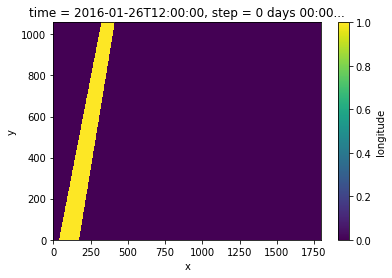

In [82]:
traindf_mask_lon.plot()

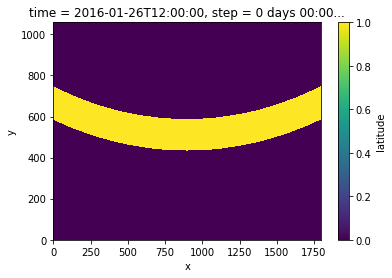

In [83]:
traindf_mask_lat.plot()

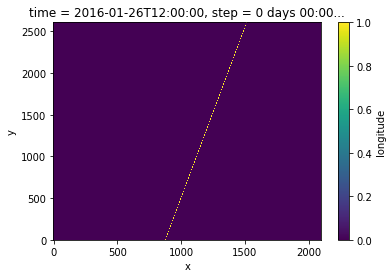

In [85]:
cell_mask_lon.plot()

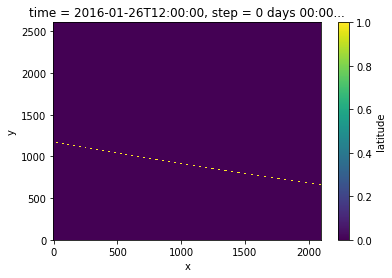

In [86]:
cell_mask_lat.plot()

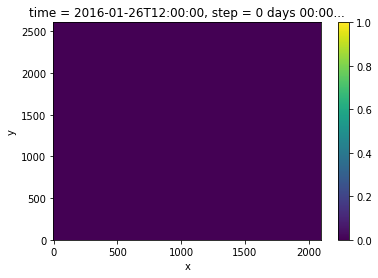

In [94]:
(cell_mask_lon & cell_mask_lat).plot()

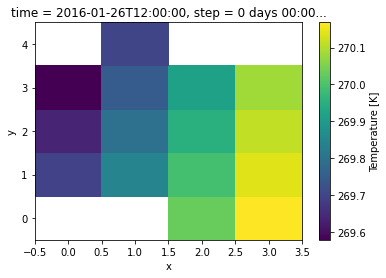

In [ ]:
cell_cropped_ds.t.plot()

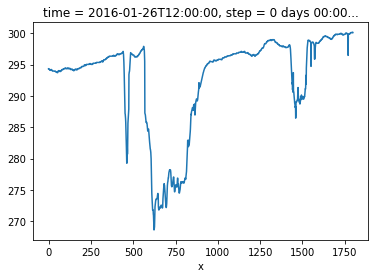

In [45]:
ds.sel(y=0).to_array().plot()

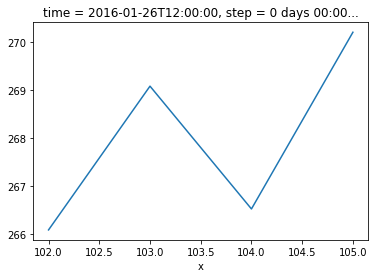

In [46]:
train_cropped_ds.sel(y=0).to_array().plot()

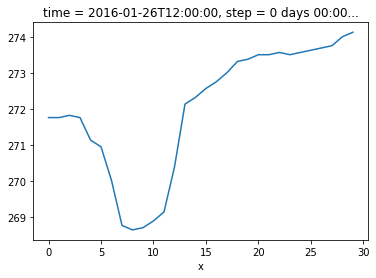

In [75]:
ds.sel(dict(y=0, x=slice(615,645))).to_array().plot()

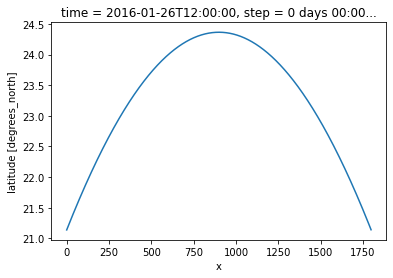

In [47]:
ds.sel(y=0).latitude.plot()

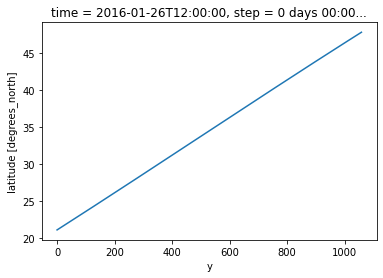

In [45]:
ds.sel(x=0).latitude.plot()

In [54]:
%%time
# Upsample from original 3km resolution, 
# aiming at interpolating 5 data points per 1km, i.e. 5*5 per 1km^2 cell
new_x = np.linspace(train_cropped_ds.x[0], train_cropped_ds.x[-1], train_cropped_ds.dims["x"] * 3*5)
new_y = np.linspace(train_cropped_ds.y[0], train_cropped_ds.y[-1], train_cropped_ds.dims["y"] * 3*5)
ds_upsampled = train_cropped_ds.interp(x=new_x, y=new_y)


CPU times: user 208 ms, sys: 3.03 ms, total: 211 ms
Wall time: 213 ms


In [211]:
%%time
# Upsample from original 3km resolution, 
# aiming at interpolating 5 data points per 1km, i.e. 5*5 per 1km^2 cell
# TKTK
new_x = np.linspace(train_cropped_ds.x[0], train_cropped_ds.x[-1], train_cropped_ds.dims["x"] * 3*5)
new_y = np.linspace(train_cropped_ds.y[0], train_cropped_ds.y[-1], train_cropped_ds.dims["y"] * 3*5)
ds_upsampled_cubic = train_cropped_ds.dropna(dim=xar_varname).interp(x=new_x, y=new_y, method="cubic")


ValueError: ignored

Adapted from https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb :

### Check the dataset value distribution


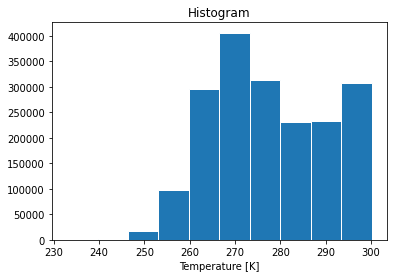

In [206]:
ds.t.plot.hist(edgecolor="white")
plt.show()

### Plot temperature 

First, let's create a Cartopy CRS (coordinate reference system) specification from the attributes in the dataset. The HRRR data comes in the Lambert conformal projection. See [this example](https://github.com/blaylockbk/HRRR_archive_download/blob/4105f21ee01ad5a915d9545008fad94cf8af8213/herbie/accessors.py#L69-L78) for more information.

In [26]:
attrs = ds.t.attrs


assert attrs['GRIB_gridType'] == 'lambert'

# Define the CRS with attributes from the temperate DataArray
prj_kwargs = dict(
    globe=ccrs.Globe(ellipse='sphere'),
    central_latitude=attrs['GRIB_LaDInDegrees'],
    central_longitude=attrs['GRIB_LoVInDegrees'],
    standard_parallels=(attrs['GRIB_Latin1InDegrees'],\
                        attrs['GRIB_Latin2InDegrees'])
)

prj = ccrs.LambertConformal(**prj_kwargs)

Now we can plot the entire CONUS with some overlaid context from `cartopy` and a nice thermal colormap from `cmocean`.

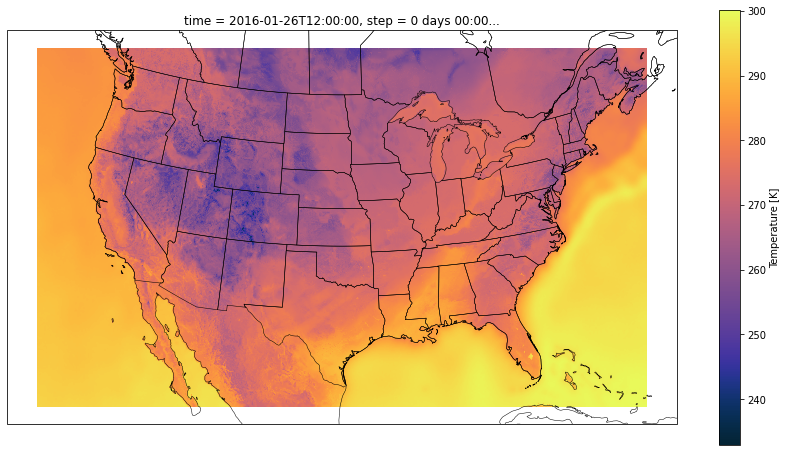

In [27]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

ds.t.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

### Plot wind

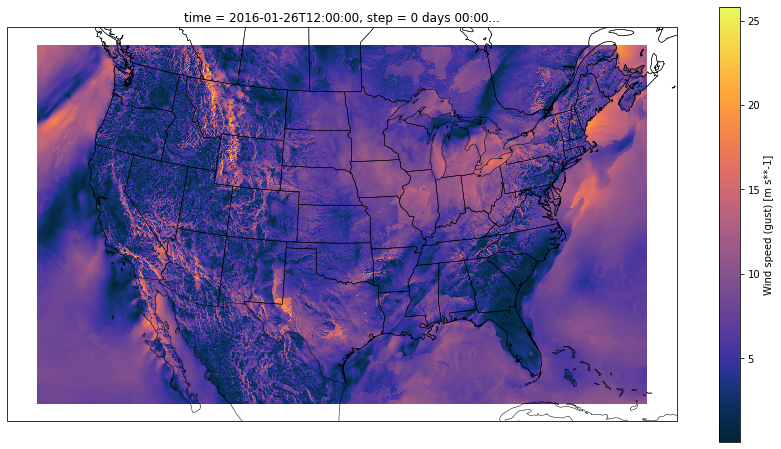

In [59]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

ds.gust.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

### Plot bounding box for training data areas

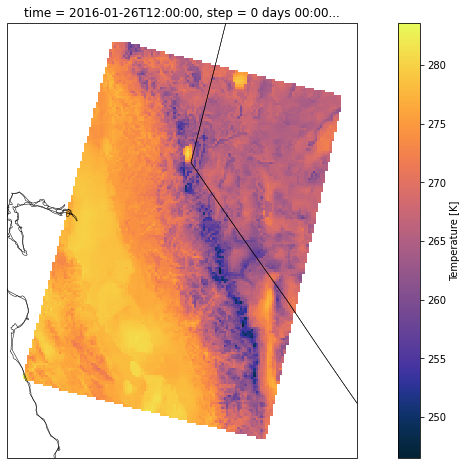

In [49]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

train_cropped_ds.t.plot(**plt_kwargs, ax=ax) 
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

### Zoom in on an areas near Lake Tahoe

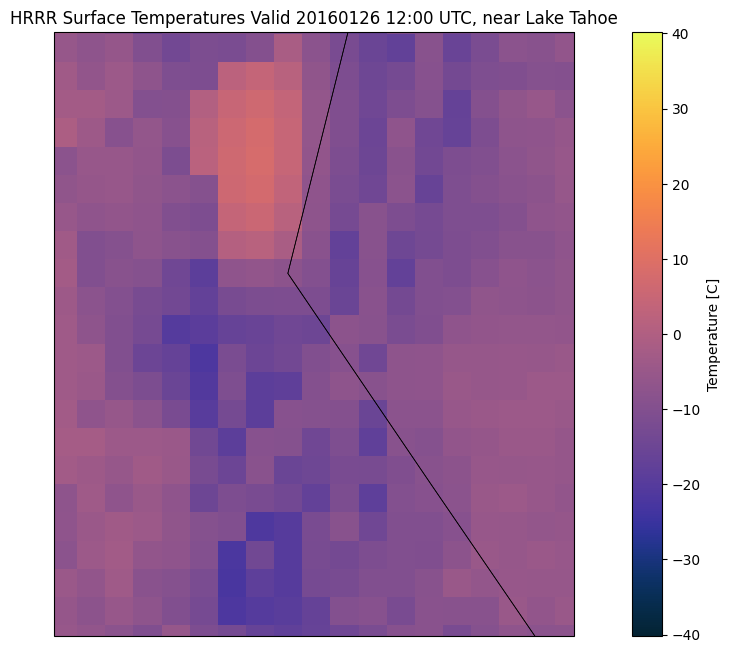

In [209]:
# Increase the dpi a bit for some crisper text
fig = plt.figure(figsize=(15,8), dpi=100)
ax = plt.axes(projection=prj)

# K to C
with xr.set_options(keep_attrs=True):
    t_c = ds.t - 273.15
    t_c.attrs["units"] = "C"

# Add some context and zoom to the SW
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
# zoom in on Lake Tahoe (top left):
ax.set_extent([-120.2, -119.7, 38.7, 39.2], crs=ccrs.PlateCarree())


t_c.plot(**plt_kwargs, ax=ax)
d = ds.coords['valid_time'].values

plt.title(f"HRRR Surface Temperatures Valid {thisdatestring} {cycle + forecast_hour:02}:00 UTC,\
 near Lake Tahoe")
plt.show()

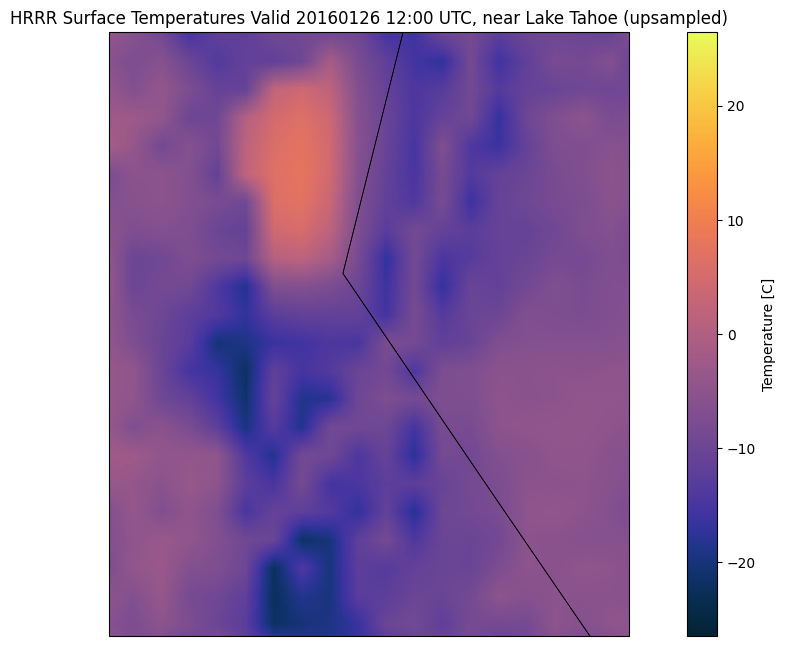

In [210]:
# Increase the dpi a bit for some crisper text
fig = plt.figure(figsize=(15,8), dpi=100)
ax = plt.axes(projection=prj)

# K to C
with xr.set_options(keep_attrs=True):
    t_c = ds_upsampled.t - 273.15
    t_c.attrs["units"] = "C"

# Add some context and zoom to the SW
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
# zoom in on Lake Tahoe (top left):
ax.set_extent([-120.2, -119.7, 38.7, 39.2], crs=ccrs.PlateCarree())


t_c.plot(**plt_kwargs, ax=ax)
d = ds_upsampled.coords['valid_time'].values

plt.title(f"HRRR Surface Temperatures Valid {thisdatestring} {cycle + forecast_hour:02}:00 UTC,\
 near Lake Tahoe (upsampled)")
plt.show()